# Set up

In [1]:
# update path with data dir
import sys
sys.path.append('../../optimiser/')

In [2]:
import pandas as pd
import patsy
import numpy as np
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import PredefinedSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import optimiser

In [3]:
import warnings
# warnings.filterwarnings('ignore')

# Getting data

In [4]:
file_name = '../csvs/element_gameweek_features_v04.csv'

In [5]:
element_gameweek_df = pd.read_csv(file_name)

In [6]:
element_gameweek_df.fillna(3, inplace=True)

In [7]:
all_element_gameweek_df = element_gameweek_df.copy()
element_gameweek_df = element_gameweek_df[element_gameweek_df['rolling_avg_minutes_element_p3'] >= 60]

In [8]:
all_element_gameweek_df['predicted_total_points'] = 0

# Evaluating models

## Helpers

### Modelling

In [9]:
formula = \
'total_points ~ C(element) + C(element_type) + C(team) + C(opposition_team) + ' + \
' + '.join([i for i in element_gameweek_df.columns if i not in
 [
     'safe_web_name',
     'element',
     'event',
     'fixture',
     'team',
     'opposition_team',
     'element_type',
     'rolling_avg_attempted_passes_element',
     'rolling_var_total_points_against_opposition_team',
     'rolling_var_total_points_own_team',
     'rolling_var_total_points_opposition_team',
     'rolling_var_total_points_element_type',
     'rolling_var_total_points_against_opposition_team_element_type',
     'expected_var_total_points_against_opposition_team',
     'expected_var_total_points_at_ground',
     'rolling_avg_total_points_home',
     'rolling_var_total_points_home',
     'rolling_avg_total_points_against_opposition_ground_element_type',
     'rolling_var_total_points_against_opposition_ground_element_type',
     'total_points',
     'minutes'
 ]])

In [10]:
scaled_feature_cols = [
    i for i in element_gameweek_df.columns if i not in [
        'safe_web_name', 'element', 'event', 'fixture', 'team',
        'opposition_team', 'element_type', 'was_home', 'is_sunday',
        'is_weekday', 'is_late', 'is_early', 'total_points'
    ]
]

### Predicting points

In [11]:
def predict_test_set(df, model, features=False, standardise=True, start=21, end=38, verbose=0):
    y_pred_arr = []
    y_test_arr = []
    event_df_test_arr = []

    # for each event we want to predict
    for e in range(start, end + 1):
        if verbose > 0:
            print('predicting event', e)
        # filter weeks after test week
        event_df = df.copy()
        event_df = event_df[event_df['event'] <= e]
        
        # define train-test split
        test_fold = [-1 if i <= e - 1 else 0 for i in event_df['event']]
        ps = PredefinedSplit(test_fold)

        # split df into train and test
        for train_index, test_index in ps.split():
            event_df_train, event_df_test = \
            event_df.copy().iloc[train_index], event_df.copy().iloc[test_index]
        
        # standardise appropriate variables if necessary
        scaled_event_df = event_df.copy()
        if standardise:
            scale_train = event_df_train.copy()
            scale_test = event_df_test.copy()
            scale_df = event_df.copy()
            scaled_event_df_train = event_df_train.copy()
            scaled_event_df_test = event_df_test.copy()

            scaler = StandardScaler().fit(scale_train[scaled_feature_cols].values)

            scale_train = scaler.transform(scale_train[scaled_feature_cols].values)
            scale_test = scaler.transform(scale_test[scaled_feature_cols].values)
            scale_df = scaler.transform(scale_df[scaled_feature_cols].values)

            scaled_event_df_train[scaled_feature_cols] = scale_train
            scaled_event_df_test[scaled_feature_cols] = scale_test
            scaled_event_df[scaled_feature_cols] = scale_df         

        # get reponse vector and feature matrix
        event_y, event_X = patsy.dmatrices(formula, scaled_event_df, return_type='matrix')
        
        # split response vector and feature matrix into train and test
        for train_index, test_index in ps.split():
            event_X_train, event_X_test = event_X[train_index], event_X[test_index]
            event_y_train, event_y_test = event_y[train_index], event_y[test_index]
        
        # get size of total feature set
        n_all_features = event_X.shape[1]
        
        # if only certain features selected, get their indices
        if features:
            features_index = np.zeros(n_all_features, dtype=bool)

            for i in range(0, n_all_features):
                j = event_X.design_info.column_names[i]
                if j in features:
                    features_index[i] = True
        # otherwise take all features
        else:
            features_index = np.ones(n_all_features, dtype=bool)
        
        # throw away features that are not selected
        event_X_train_sel = event_X_train[:,features_index]
        event_X_test_sel = event_X_test[:,features_index]

        # fit model on training data
        model.fit(event_X_train_sel, event_y_train.ravel())
        # predict test event
        event_y_pred = model.predict(event_X_test_sel).flatten()
        
        # collect predictions and observations 
        y_pred_arr.append(event_y_pred)
        y_test_arr.append(event_y_test)
        
        event_df_test['predicted_total_points'] = event_y_pred
        event_df_test_arr.append(event_df_test)
        
    
    return np.concatenate(y_pred_arr).ravel(), np.concatenate(y_test_arr).ravel(), pd.concat(event_df_test_arr)

### Constructing teams

In [12]:
def construct_event_teams_from_scratch(df,
                                       optimise_key='predicted_total_points',
                                       start=21,
                                       end=38,
                                       total_budget=1000,
                                       verbose=0):
    first_team_arr = []
    bench_arr = []
    team_total_points_arr = []
    predicted_team_total_points_arr = []
    team_df_arr = []

    for e in range(start, end + 1):
        if verbose > 0:
            print('predicting event', e)
        
        event_players = df.copy()
        event_players = event_players[event_players['event'] == e]

        event_players_group = event_players.groupby('element')[optimise_key].sum()
        event_players = event_players[['element', 'value', 'element_type', 'team']].drop_duplicates()

        event_players = event_players.join(event_players_group, on='element')
        
        event_players = event_players.to_dict('records')

        try:
            event_first_team, event_bench = \
            optimiser.construct_optimal_team_from_scratch(
                event_players,
                optimise_key=optimise_key,
                total_budget=total_budget)

            first_team_arr.append(event_first_team)
            bench_arr.append(event_bench)
        except Exception as ex:
            print(e, ex)
            continue
    
        event_team_total_points, event_team_predicted_total_points, event_team_df = \
        optimiser.calculate_team_total_points(df[df['event'] == e], event_first_team, event_bench)

        team_total_points_arr.append(event_team_total_points)
        predicted_team_total_points_arr.append(event_team_predicted_total_points)
        team_df_arr.append(event_team_df)
    
    return first_team_arr, bench_arr, team_total_points_arr, predicted_team_total_points_arr, team_df_arr

In [13]:
def construct_event_teams_from_existing(df,
                                        optimise_key='predicted_total_points',
                                        total_budget=1000,
                                        start=21,
                                        end=38,
                                        transfer_penalty=4,
                                        transfer_limit=11,
                                        verbose=0):
    first_team_arr = []
    bench_arr = []
    team_total_points_arr = []
    predicted_team_total_points_arr = []
    team_df_arr = []
    transfers_arr = []
    carried_over_transfers = 0

    for e in range(start, end + 1):
        if verbose > 0:
            print('predicting event', e)
        
        event_players = df.copy()
        event_players = event_players[event_players['event'] == e]
        

        present_elements = event_players['element'].drop_duplicates().values
        
        all_df = all_element_gameweek_df.copy()
        all_df = all_df[all_df['event'] == e]
        
        event_players = pd.concat([event_players, all_df[~all_df['element'].isin(present_elements)]])
        event_players_df = event_players.copy()

        event_players_group = event_players.groupby('element')[optimise_key].sum()
        event_players = event_players[['element', 'value', 'element_type', 'team']].drop_duplicates()

        event_players = event_players.join(event_players_group, on='element')
        
        event_players = event_players.to_dict('records')
        
        if e == start:
            try:
                event_first_team, event_bench = \
                optimiser.construct_optimal_team_from_scratch(
                    event_players,
                    optimise_key=optimise_key,
                    total_budget=total_budget
                )

                first_team_arr.append(event_first_team)
                bench_arr.append(event_bench)
                transfers_arr.append([])
                
                event_num_transfers = 1
            except Exception as ex:
                print(e, ex)
                first_team_arr.append([])
                bench_arr.append([])
                transfers_arr.append([])
                
                event_num_transfers = 1
        else:
            try:
                event_first_team, event_bench, event_transfers = \
                optimiser.construct_optimal_team_from_existing(
                    event_players,
                    event_first_team,
                    event_bench,
                    total_budget=total_budget,
                    optimise_key=optimise_key,
                    transfer_penalty=transfer_penalty,
                    transfer_limit=transfer_limit
                )

                first_team_arr.append(event_first_team)
                bench_arr.append(event_bench)
                transfers_arr.append(event_transfers)
                
                event_num_transfers = len(event_transfers[0])
            except Exception as ex:
                print(e, ex)
                first_team_arr.append([])
                bench_arr.append([])
                transfers_arr.append([])
                
                event_num_transfers = 0
        
        event_num_transfers = max(event_num_transfers - carried_over_transfers, 0)
        
        event_team_total_points, event_team_predicted_total_points, event_team_df = \
        optimiser.calculate_team_total_points(event_players_df,
                                              event_first_team,
                                              event_bench,
                                              event_num_transfers,
                                              carried_over_transfers)
        
        if event_num_transfers == 0 and carried_over_transfers == 0:
            carried_over_transfers = 1
        if event_num_transfers in (0, 1) and carried_over_transfers == 1:
            carried_over_transfers = 1
        if event_num_transfers == 1 and carried_over_transfers == 0:
            carried_over_transfers = 0
        if event_num_transfers > 1:
            carried_over_transfers = 0


        team_total_points_arr.append(event_team_total_points)
        predicted_team_total_points_arr.append(event_team_predicted_total_points)
        team_df_arr.append(event_team_df)
    
    return (
        first_team_arr, bench_arr,
        team_total_points_arr,
        predicted_team_total_points_arr,
        team_df_arr,
        transfers_arr
    )

## Predicting points

### Linear regression

In [14]:
lr_model = LinearRegression()

In [15]:
lr_features = [
    'C(element)[T.183]',
    'C(element)[T.189]',
    'C(element)[T.511]',
    'C(element)[T.512]'
]

In [16]:
lr_y_pred, lr_y_test, lr_df_test = predict_test_set(
    element_gameweek_df,
    lr_model,
    features=lr_features,
    standardise=True
)

In [17]:
lr_test_loss = (
    mean_absolute_error(lr_y_test, lr_y_pred),
    mean_squared_error(lr_y_test, lr_y_pred),
    r2_score(lr_y_test, lr_y_pred)
)
lr_test_loss

(2.3891621767560127, 10.275134773295774, -0.00025733139878769684)

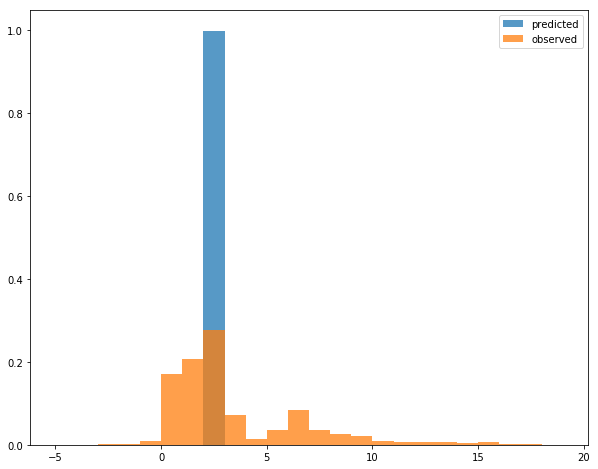

In [18]:
plt.figure(figsize=(10, 8))
plt.hist(pd.Series(lr_y_pred), bins=range(-5,20), alpha=0.75, density=True, label='predicted')
plt.hist(pd.Series(lr_y_test), bins=range(-5,20), alpha=0.75, density=True, label='observed')
plt.legend()
plt.show()

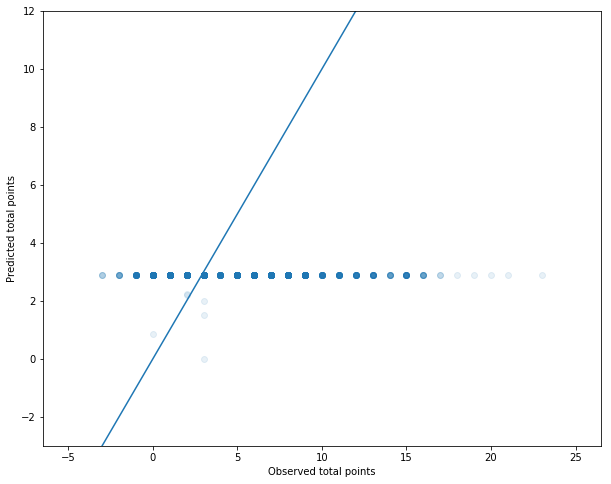

In [19]:
plt.figure(figsize=(10, 8))
plt.scatter(pd.Series(lr_y_test), pd.Series(lr_y_pred), alpha=0.1)
plt.plot(np.linspace(-5, 25), np.linspace(-5, 25))
plt.ylabel('Predicted total points')
plt.xlabel('Observed total points')
plt.ylim((-3, 12))
plt.show()

### Ridge regression (lush)

In [20]:
lush_ridge_model = Ridge(alpha=270)

In [21]:
lush_ridge_features = [
    'C(element)[T.4]', 'C(element)[T.6]', 'C(element)[T.12]',
    'C(element)[T.14]', 'C(element)[T.18]', 'C(element)[T.22]',
    'C(element)[T.23]', 'C(element)[T.24]', 'C(element)[T.27]',
    'C(element)[T.28]', 'C(element)[T.33]', 'C(element)[T.37]',
    'C(element)[T.39]', 'C(element)[T.40]', 'C(element)[T.43]',
    'C(element)[T.48]', 'C(element)[T.49]', 'C(element)[T.50]',
    'C(element)[T.54]', 'C(element)[T.56]', 'C(element)[T.58]',
    'C(element)[T.60]', 'C(element)[T.61]', 'C(element)[T.62]',
    'C(element)[T.69]', 'C(element)[T.71]', 'C(element)[T.73]',
    'C(element)[T.75]', 'C(element)[T.76]', 'C(element)[T.77]',
    'C(element)[T.79]', 'C(element)[T.80]', 'C(element)[T.82]',
    'C(element)[T.84]', 'C(element)[T.85]', 'C(element)[T.88]',
    'C(element)[T.90]', 'C(element)[T.91]', 'C(element)[T.94]',
    'C(element)[T.95]', 'C(element)[T.98]', 'C(element)[T.99]',
    'C(element)[T.101]', 'C(element)[T.102]', 'C(element)[T.106]',
    'C(element)[T.110]', 'C(element)[T.115]', 'C(element)[T.116]',
    'C(element)[T.122]', 'C(element)[T.124]', 'C(element)[T.125]',
    'C(element)[T.126]', 'C(element)[T.127]', 'C(element)[T.134]',
    'C(element)[T.137]', 'C(element)[T.140]', 'C(element)[T.142]',
    'C(element)[T.145]', 'C(element)[T.147]', 'C(element)[T.149]',
    'C(element)[T.150]', 'C(element)[T.151]', 'C(element)[T.152]',
    'C(element)[T.156]', 'C(element)[T.157]', 'C(element)[T.160]',
    'C(element)[T.168]', 'C(element)[T.169]', 'C(element)[T.172]',
    'C(element)[T.175]', 'C(element)[T.177]', 'C(element)[T.178]',
    'C(element)[T.181]', 'C(element)[T.183]', 'C(element)[T.190]',
    'C(element)[T.192]', 'C(element)[T.195]', 'C(element)[T.197]',
    'C(element)[T.198]', 'C(element)[T.202]', 'C(element)[T.206]',
    'C(element)[T.210]', 'C(element)[T.211]', 'C(element)[T.215]',
    'C(element)[T.219]', 'C(element)[T.220]', 'C(element)[T.221]',
    'C(element)[T.225]', 'C(element)[T.226]', 'C(element)[T.227]',
    'C(element)[T.234]', 'C(element)[T.236]', 'C(element)[T.239]',
    'C(element)[T.243]', 'C(element)[T.245]', 'C(element)[T.246]',
    'C(element)[T.247]', 'C(element)[T.249]', 'C(element)[T.251]',
    'C(element)[T.252]', 'C(element)[T.253]', 'C(element)[T.254]',
    'C(element)[T.256]', 'C(element)[T.257]', 'C(element)[T.258]',
    'C(element)[T.260]', 'C(element)[T.262]', 'C(element)[T.263]',
    'C(element)[T.265]', 'C(element)[T.267]', 'C(element)[T.268]',
    'C(element)[T.269]', 'C(element)[T.270]', 'C(element)[T.271]',
    'C(element)[T.276]', 'C(element)[T.280]', 'C(element)[T.282]',
    'C(element)[T.288]', 'C(element)[T.289]', 'C(element)[T.291]',
    'C(element)[T.295]', 'C(element)[T.297]', 'C(element)[T.299]',
    'C(element)[T.300]', 'C(element)[T.301]', 'C(element)[T.304]',
    'C(element)[T.305]', 'C(element)[T.306]', 'C(element)[T.309]',
    'C(element)[T.310]', 'C(element)[T.312]', 'C(element)[T.315]',
    'C(element)[T.317]', 'C(element)[T.318]', 'C(element)[T.319]',
    'C(element)[T.324]', 'C(element)[T.326]', 'C(element)[T.327]',
    'C(element)[T.330]', 'C(element)[T.332]', 'C(element)[T.333]',
    'C(element)[T.343]', 'C(element)[T.346]', 'C(element)[T.351]',
    'C(element)[T.352]', 'C(element)[T.353]', 'C(element)[T.355]',
    'C(element)[T.356]', 'C(element)[T.357]', 'C(element)[T.359]',
    'C(element)[T.363]', 'C(element)[T.364]', 'C(element)[T.365]',
    'C(element)[T.367]', 'C(element)[T.368]', 'C(element)[T.370]',
    'C(element)[T.380]', 'C(element)[T.382]', 'C(element)[T.383]',
    'C(element)[T.386]', 'C(element)[T.389]', 'C(element)[T.390]',
    'C(element)[T.391]', 'C(element)[T.392]', 'C(element)[T.393]',
    'C(element)[T.395]', 'C(element)[T.396]', 'C(element)[T.400]',
    'C(element)[T.402]', 'C(element)[T.403]', 'C(element)[T.408]',
    'C(element)[T.411]', 'C(element)[T.415]', 'C(element)[T.417]',
    'C(element)[T.423]', 'C(element)[T.425]', 'C(element)[T.426]',
    'C(element)[T.432]', 'C(element)[T.433]', 'C(element)[T.435]',
    'C(element)[T.437]', 'C(element)[T.447]', 'C(element)[T.450]',
    'C(element)[T.451]', 'C(element)[T.455]', 'C(element)[T.459]',
    'C(element)[T.461]', 'C(element)[T.462]', 'C(element)[T.463]',
    'C(element)[T.464]', 'C(element)[T.465]', 'C(element)[T.467]',
    'C(element)[T.468]', 'C(element)[T.473]', 'C(element)[T.474]',
    'C(element)[T.475]', 'C(element)[T.476]', 'C(element)[T.480]',
    'C(element)[T.483]', 'C(element)[T.484]', 'C(element)[T.487]',
    'C(element)[T.488]', 'C(element)[T.489]', 'C(element)[T.493]',
    'C(element)[T.503]', 'C(element)[T.504]', 'C(element)[T.505]',
    'C(element)[T.509]', 'C(element)[T.511]', 'C(element)[T.516]',
    'C(element)[T.536]', 'C(element)[T.539]', 'C(element)[T.549]',
    'C(element_type)[T.2]', 'C(element_type)[T.3]', 'C(element_type)[T.4]',
    'C(team)[T.3]', 'C(team)[T.4]', 'C(team)[T.6]', 'C(team)[T.7]',
    'C(team)[T.8]', 'C(team)[T.9]', 'C(team)[T.10]', 'C(team)[T.12]',
    'C(team)[T.14]', 'C(team)[T.15]', 'C(team)[T.16]', 'C(team)[T.17]',
    'C(team)[T.19]', 'C(team)[T.20]', 'C(opposition_team)[T.2]',
    'C(opposition_team)[T.3]', 'C(opposition_team)[T.4]',
    'C(opposition_team)[T.5]', 'C(opposition_team)[T.6]',
    'C(opposition_team)[T.7]', 'C(opposition_team)[T.9]',
    'C(opposition_team)[T.10]', 'C(opposition_team)[T.11]',
    'C(opposition_team)[T.12]', 'C(opposition_team)[T.13]',
    'C(opposition_team)[T.15]', 'C(opposition_team)[T.16]',
    'C(opposition_team)[T.17]', 'C(opposition_team)[T.18]',
    'C(opposition_team)[T.19]', 'was_home', 'value', 'is_sunday', 'is_weekday',
    'is_late', 'is_early', 'rolling_var_total_points_element',
    'rolling_max_total_points_element', 'rolling_avg_minutes_element_p3',
    'rolling_avg_goals_scored_element', 'rolling_avg_minutes_element',
    'rolling_avg_winning_goals_element',
    'rolling_avg_clearances_blocks_interceptions_element',
    'rolling_avg_big_chances_created_element', 'rolling_avg_offside_element',
    'rolling_avg_big_chances_missed_element',
    'rolling_avg_goals_conceded_element', 'rolling_avg_total_points_own_team',
    'rolling_avg_total_points_opposition_team',
    'rolling_avg_total_points_against_opposition_team'
]

In [22]:
lush_ridge_y_pred, lush_ridge_y_test, lush_ridge_df_test = predict_test_set(
    element_gameweek_df,
    lush_ridge_model,
    features=lush_ridge_features,
    standardise=True
)

In [23]:
lush_ridge_test_loss = (
    mean_absolute_error(lush_ridge_y_test, lush_ridge_y_pred),
    mean_squared_error(lush_ridge_y_test, lush_ridge_y_pred),
    r2_score(lush_ridge_y_test, lush_ridge_y_pred)
)
lush_ridge_test_loss

(2.259268449409939, 9.308153996546018, 0.09387570263005907)

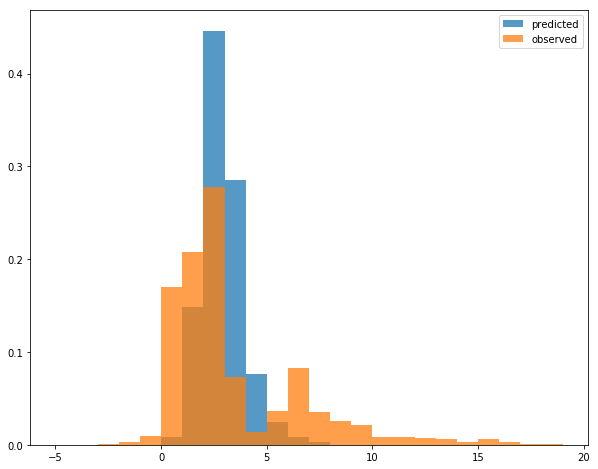

In [24]:
plt.figure(figsize=(10, 8))
plt.hist(pd.Series(lush_ridge_y_pred), bins=range(-5,20), alpha=0.75, density=True, label='predicted')
plt.hist(pd.Series(lush_ridge_y_test), bins=range(-5,20), alpha=0.75, density=True, label='observed')
plt.legend()
plt.show()

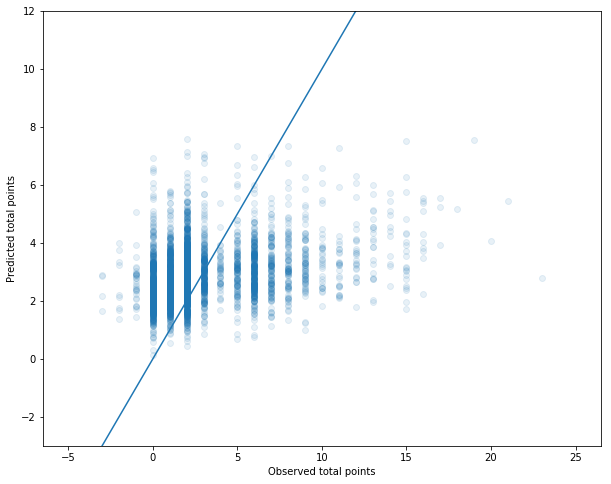

In [25]:
plt.figure(figsize=(10, 8))
plt.scatter(pd.Series(lush_ridge_y_test), pd.Series(lush_ridge_y_pred), alpha=0.1)
plt.plot(np.linspace(-5, 25), np.linspace(-5, 25))
plt.ylabel('Predicted total points')
plt.xlabel('Observed total points')
plt.ylim((-3, 12))
plt.show()

### Ridge regression (stark)

In [26]:
stark_ridge_model = Ridge(alpha=1e-8)

In [27]:
stark_ridge_features = [
    'C(element)[T.40]', 'C(element)[T.43]', 'C(element)[T.49]',
    'C(element)[T.69]', 'C(element)[T.91]', 'C(element)[T.115]',
    'C(element)[T.116]', 'C(element)[T.122]', 'C(element)[T.134]',
    'C(element)[T.172]', 'C(element)[T.221]', 'C(element)[T.234]',
    'C(element)[T.245]', 'C(element)[T.246]', 'C(element)[T.247]',
    'C(element)[T.262]', 'C(element)[T.295]', 'C(element)[T.301]',
    'C(element)[T.306]', 'C(element)[T.333]', 'C(element)[T.356]',
    'C(element)[T.364]', 'C(element)[T.365]', 'C(element)[T.391]',
    'C(element)[T.411]', 'C(element)[T.423]', 'C(element)[T.425]',
    'C(element)[T.437]', 'C(element)[T.462]', 'C(element)[T.465]',
    'C(element)[T.484]', 'C(element_type)[T.2]', 'C(element_type)[T.3]',
    'C(element_type)[T.4]', 'C(opposition_team)[T.9]',
    'C(opposition_team)[T.12]', 'C(opposition_team)[T.13]', 'value'
]

In [28]:
stark_ridge_y_pred, stark_ridge_y_test, stark_ridge_df_test = predict_test_set(
    element_gameweek_df,
    stark_ridge_model,
    features=stark_ridge_features,
    standardise=True
)

In [29]:
stark_ridge_test_loss = (
    mean_absolute_error(stark_ridge_y_test, stark_ridge_y_pred),
    mean_squared_error(stark_ridge_y_test, stark_ridge_y_pred),
    r2_score(stark_ridge_y_test, stark_ridge_y_pred)
)
stark_ridge_test_loss

(2.2825443585935585, 9.594886878178908, 0.06596301113410075)

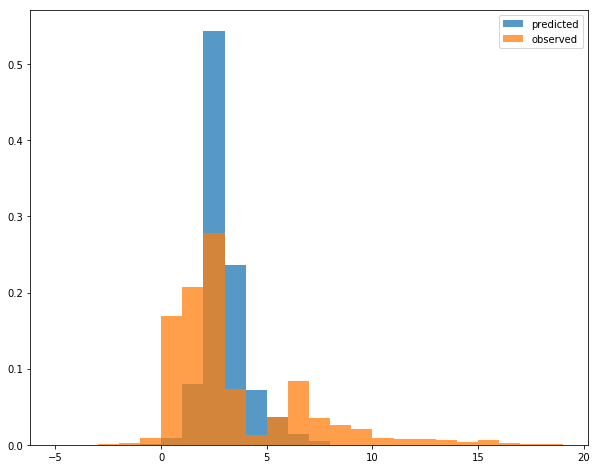

In [30]:
plt.figure(figsize=(10, 8))
plt.hist(pd.Series(stark_ridge_y_pred), bins=range(-5,20), alpha=0.75, density=True, label='predicted')
plt.hist(pd.Series(stark_ridge_y_test), bins=range(-5,20), alpha=0.75, density=True, label='observed')
plt.legend()
plt.show()

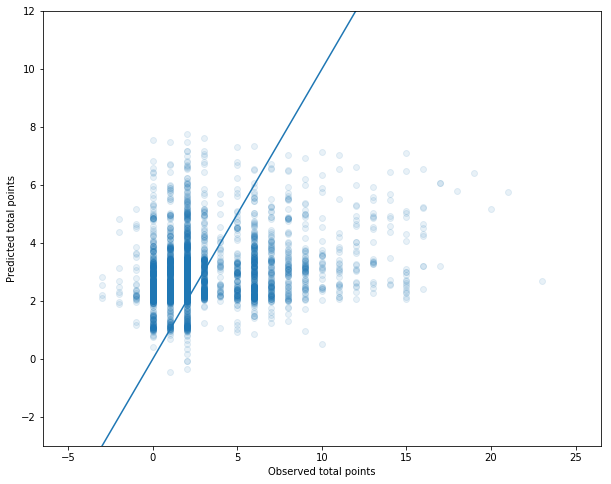

In [31]:
plt.figure(figsize=(10, 8))
plt.scatter(pd.Series(stark_ridge_y_test), pd.Series(stark_ridge_y_pred), alpha=0.1)
plt.plot(np.linspace(-5, 25), np.linspace(-5, 25))
plt.ylabel('Predicted total points')
plt.xlabel('Observed total points')
plt.ylim((-3, 12))
plt.show()

### Lasso regression

In [32]:
lasso_model = Lasso(alpha=1e-8)

In [33]:
lasso_features = ['expected_avg_total_points_at_ground']

In [34]:
lasso_y_pred, lasso_y_test, lasso_df_test = predict_test_set(
    element_gameweek_df,
    lasso_model,
    features=lasso_features,
    standardise=True
)

In [35]:
lasso_test_loss = (
    mean_absolute_error(lasso_y_test, lasso_y_pred),
    mean_squared_error(lasso_y_test, lasso_y_pred),
    r2_score(lasso_y_test, lasso_y_pred)
)
lasso_test_loss

(2.2973044429258143, 9.691293860592644, 0.056578045088887086)

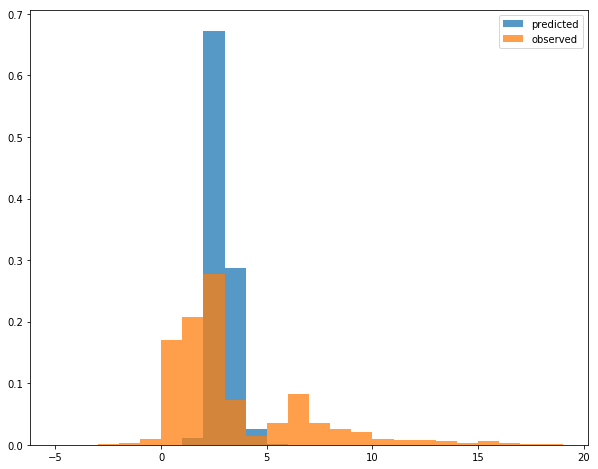

In [36]:
plt.figure(figsize=(10, 8))
plt.hist(pd.Series(lasso_y_pred), bins=range(-5,20), alpha=0.75, density=True, label='predicted')
plt.hist(pd.Series(lasso_y_test), bins=range(-5,20), alpha=0.75, density=True, label='observed')
plt.legend()
plt.show()

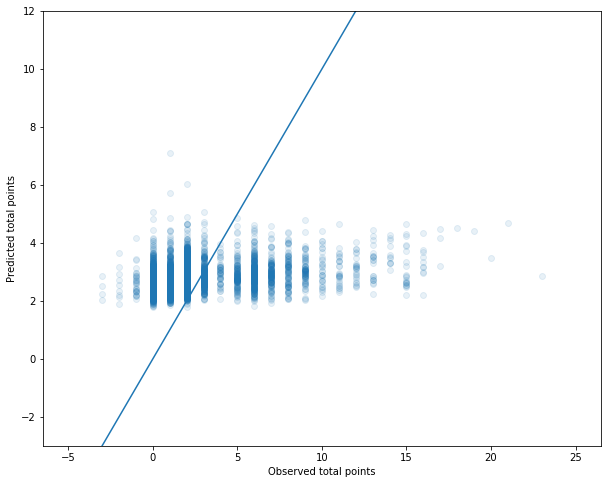

In [37]:
plt.figure(figsize=(10, 8))
plt.scatter(pd.Series(lasso_y_test), pd.Series(lasso_y_pred), alpha=0.1)
plt.plot(np.linspace(-5, 25), np.linspace(-5, 25))
plt.ylabel('Predicted total points')
plt.xlabel('Observed total points')
plt.ylim((-3, 12))
plt.show()

### Radial basis SVM regression

In [96]:
rbf_svr_model = SVR(kernel='rbf', gamma=0.012, C=1.5, epsilon=2.07)

In [97]:
rbf_svr_features = [
    'C(element)[T.4]', 'C(element)[T.6]', 'C(element)[T.8]',
    'C(element)[T.12]', 'C(element)[T.13]', 'C(element)[T.14]',
    'C(element)[T.18]', 'C(element)[T.23]', 'C(element)[T.33]',
    'C(element)[T.37]', 'C(element)[T.39]', 'C(element)[T.40]',
    'C(element)[T.42]', 'C(element)[T.43]', 'C(element)[T.48]',
    'C(element)[T.49]', 'C(element)[T.50]', 'C(element)[T.54]',
    'C(element)[T.55]', 'C(element)[T.56]', 'C(element)[T.57]',
    'C(element)[T.58]', 'C(element)[T.60]', 'C(element)[T.62]',
    'C(element)[T.66]', 'C(element)[T.69]', 'C(element)[T.71]',
    'C(element)[T.72]', 'C(element)[T.73]', 'C(element)[T.75]',
    'C(element)[T.76]', 'C(element)[T.77]', 'C(element)[T.79]',
    'C(element)[T.80]', 'C(element)[T.82]', 'C(element)[T.83]',
    'C(element)[T.84]', 'C(element)[T.85]', 'C(element)[T.88]',
    'C(element)[T.90]', 'C(element)[T.91]', 'C(element)[T.92]',
    'C(element)[T.95]', 'C(element)[T.98]', 'C(element)[T.101]',
    'C(element)[T.105]', 'C(element)[T.110]', 'C(element)[T.113]',
    'C(element)[T.115]', 'C(element)[T.116]', 'C(element)[T.118]',
    'C(element)[T.124]', 'C(element)[T.126]', 'C(element)[T.127]',
    'C(element)[T.134]', 'C(element)[T.137]', 'C(element)[T.140]',
    'C(element)[T.141]', 'C(element)[T.145]', 'C(element)[T.147]',
    'C(element)[T.152]', 'C(element)[T.156]', 'C(element)[T.157]',
    'C(element)[T.160]', 'C(element)[T.164]', 'C(element)[T.167]',
    'C(element)[T.168]', 'C(element)[T.169]', 'C(element)[T.172]',
    'C(element)[T.175]', 'C(element)[T.178]', 'C(element)[T.181]',
    'C(element)[T.183]', 'C(element)[T.184]', 'C(element)[T.189]',
    'C(element)[T.190]', 'C(element)[T.191]', 'C(element)[T.192]',
    'C(element)[T.193]', 'C(element)[T.195]', 'C(element)[T.198]',
    'C(element)[T.199]', 'C(element)[T.200]', 'C(element)[T.202]',
    'C(element)[T.206]', 'C(element)[T.210]', 'C(element)[T.211]',
    'C(element)[T.213]', 'C(element)[T.215]', 'C(element)[T.219]',
    'C(element)[T.221]', 'C(element)[T.225]', 'C(element)[T.226]',
    'C(element)[T.231]', 'C(element)[T.233]', 'C(element)[T.234]',
    'C(element)[T.236]', 'C(element)[T.242]', 'C(element)[T.243]',
    'C(element)[T.245]', 'C(element)[T.246]', 'C(element)[T.247]',
    'C(element)[T.249]', 'C(element)[T.251]', 'C(element)[T.252]',
    'C(element)[T.253]', 'C(element)[T.254]', 'C(element)[T.256]',
    'C(element)[T.257]', 'C(element)[T.258]', 'C(element)[T.260]',
    'C(element)[T.262]', 'C(element)[T.263]', 'C(element)[T.264]',
    'C(element)[T.265]', 'C(element)[T.268]', 'C(element)[T.269]',
    'C(element)[T.270]', 'C(element)[T.271]', 'C(element)[T.272]',
    'C(element)[T.274]', 'C(element)[T.275]', 'C(element)[T.280]',
    'C(element)[T.281]', 'C(element)[T.282]', 'C(element)[T.288]',
    'C(element)[T.289]', 'C(element)[T.291]', 'C(element)[T.294]',
    'C(element)[T.295]', 'C(element)[T.299]', 'C(element)[T.300]',
    'C(element)[T.301]', 'C(element)[T.302]', 'C(element)[T.304]',
    'C(element)[T.305]', 'C(element)[T.306]', 'C(element)[T.309]',
    'C(element)[T.312]', 'C(element)[T.315]', 'C(element)[T.317]',
    'C(element)[T.318]', 'C(element)[T.324]', 'C(element)[T.327]',
    'C(element)[T.328]', 'C(element)[T.331]', 'C(element)[T.332]',
    'C(element)[T.333]', 'C(element)[T.335]', 'C(element)[T.336]',
    'C(element)[T.343]', 'C(element)[T.344]', 'C(element)[T.346]',
    'C(element)[T.352]', 'C(element)[T.353]', 'C(element)[T.355]',
    'C(element)[T.356]', 'C(element)[T.357]', 'C(element)[T.360]',
    'C(element)[T.362]', 'C(element)[T.364]', 'C(element)[T.365]',
    'C(element)[T.368]', 'C(element)[T.369]', 'C(element)[T.370]',
    'C(element)[T.372]', 'C(element)[T.376]', 'C(element)[T.380]',
    'C(element)[T.386]', 'C(element)[T.390]', 'C(element)[T.391]',
    'C(element)[T.393]', 'C(element)[T.394]', 'C(element)[T.395]',
    'C(element)[T.396]', 'C(element)[T.400]', 'C(element)[T.402]',
    'C(element)[T.403]', 'C(element)[T.408]', 'C(element)[T.411]',
    'C(element)[T.415]', 'C(element)[T.417]', 'C(element)[T.419]',
    'C(element)[T.423]', 'C(element)[T.425]', 'C(element)[T.426]',
    'C(element)[T.427]', 'C(element)[T.431]', 'C(element)[T.432]',
    'C(element)[T.433]', 'C(element)[T.437]', 'C(element)[T.447]',
    'C(element)[T.450]', 'C(element)[T.451]', 'C(element)[T.455]',
    'C(element)[T.456]', 'C(element)[T.459]', 'C(element)[T.461]',
    'C(element)[T.462]', 'C(element)[T.465]', 'C(element)[T.467]',
    'C(element)[T.468]', 'C(element)[T.473]', 'C(element)[T.474]',
    'C(element)[T.475]', 'C(element)[T.476]', 'C(element)[T.478]',
    'C(element)[T.479]', 'C(element)[T.480]', 'C(element)[T.482]',
    'C(element)[T.483]', 'C(element)[T.484]', 'C(element)[T.487]',
    'C(element)[T.488]', 'C(element)[T.490]', 'C(element)[T.492]',
    'C(element)[T.493]', 'C(element)[T.499]', 'C(element)[T.503]',
    'C(element)[T.504]', 'C(element)[T.505]', 'C(element)[T.506]',
    'C(element)[T.509]', 'C(element)[T.510]', 'C(element)[T.511]',
    'C(element)[T.512]', 'C(element)[T.513]', 'C(element)[T.516]',
    'C(element)[T.517]', 'C(element)[T.526]', 'C(element)[T.527]',
    'C(element)[T.536]', 'C(element)[T.539]', 'C(element)[T.549]',
    'C(element_type)[T.2]', 'C(element_type)[T.3]', 'C(element_type)[T.4]',
    'C(team)[T.6]', 'C(team)[T.7]', 'C(team)[T.8]', 'C(team)[T.10]',
    'C(team)[T.12]', 'C(team)[T.14]', 'C(team)[T.16]', 'C(team)[T.17]',
    'C(team)[T.20]', 'C(opposition_team)[T.2]', 'C(opposition_team)[T.3]',
    'C(opposition_team)[T.4]', 'C(opposition_team)[T.5]',
    'C(opposition_team)[T.6]', 'C(opposition_team)[T.7]',
    'C(opposition_team)[T.8]', 'C(opposition_team)[T.9]',
    'C(opposition_team)[T.10]', 'C(opposition_team)[T.12]',
    'C(opposition_team)[T.13]', 'C(opposition_team)[T.14]',
    'C(opposition_team)[T.15]', 'C(opposition_team)[T.16]',
    'C(opposition_team)[T.17]', 'C(opposition_team)[T.18]',
    'C(opposition_team)[T.19]', 'C(opposition_team)[T.20]', 'value',
    'is_sunday', 'is_weekday', 'rolling_avg_minutes_element_p3',
    'rolling_avg_bps_element', 'rolling_avg_goals_scored_element',
    'rolling_avg_completed_passes_element', 'rolling_avg_tackled_element',
    'rolling_avg_dribbles_element', 'rolling_avg_offside_element',
    'rolling_avg_total_points_against_opposition_team',
    'expected_avg_total_points_against_opposition_team'
]

In [ ]:
rbf_svr_y_pred, rbf_svr_y_test, rbf_svr_df_test = predict_test_set(
    element_gameweek_df,
    rbf_svr_model,
    features=rbf_svr_features,
    standardise=True
)

In [ ]:
rbf_svr_test_loss = (
    mean_absolute_error(rbf_svr_y_test, rbf_svr_y_pred),
    mean_squared_error(rbf_svr_y_test, rbf_svr_y_pred),
    r2_score(rbf_svr_y_test, rbf_svr_y_pred)
)
rbf_svr_test_loss

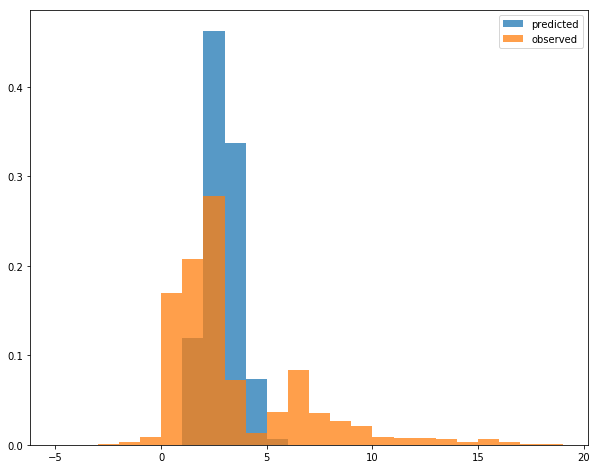

In [42]:
plt.figure(figsize=(10, 8))
plt.hist(pd.Series(rbf_svr_y_pred), bins=range(-5,20), alpha=0.75, density=True, label='predicted')
plt.hist(pd.Series(rbf_svr_y_test), bins=range(-5,20), alpha=0.75, density=True, label='observed')
plt.legend()
plt.show()

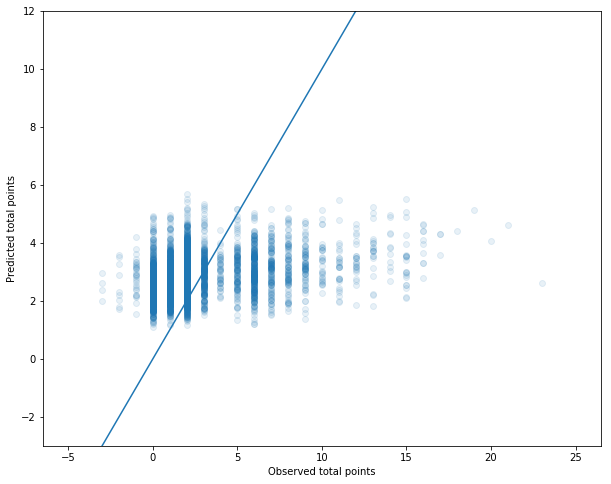

In [43]:
plt.figure(figsize=(10, 8))
plt.scatter(pd.Series(rbf_svr_y_test), pd.Series(rbf_svr_y_pred), alpha=0.1)
plt.plot(np.linspace(-5, 25), np.linspace(-5, 25))
plt.ylabel('Predicted total points')
plt.xlabel('Observed total points')
plt.ylim((-3, 12))
plt.show()

### Linear SVM regression

In [44]:
linear_svr_model = SVR(kernel='linear', C=0.29, epsilon=2.16)

In [45]:
linear_svr_features = [
    'C(element)[T.4]', 'C(element)[T.6]', 'C(element)[T.8]',
    'C(element)[T.12]', 'C(element)[T.13]', 'C(element)[T.14]',
    'C(element)[T.18]', 'C(element)[T.23]', 'C(element)[T.33]',
    'C(element)[T.37]', 'C(element)[T.39]', 'C(element)[T.40]',
    'C(element)[T.42]', 'C(element)[T.43]', 'C(element)[T.48]',
    'C(element)[T.49]', 'C(element)[T.50]', 'C(element)[T.54]',
    'C(element)[T.55]', 'C(element)[T.56]', 'C(element)[T.57]',
    'C(element)[T.58]', 'C(element)[T.60]', 'C(element)[T.62]',
    'C(element)[T.66]', 'C(element)[T.69]', 'C(element)[T.71]',
    'C(element)[T.72]', 'C(element)[T.73]', 'C(element)[T.75]',
    'C(element)[T.76]', 'C(element)[T.77]', 'C(element)[T.79]',
    'C(element)[T.80]', 'C(element)[T.82]', 'C(element)[T.83]',
    'C(element)[T.84]', 'C(element)[T.85]', 'C(element)[T.88]',
    'C(element)[T.90]', 'C(element)[T.91]', 'C(element)[T.92]',
    'C(element)[T.95]', 'C(element)[T.98]', 'C(element)[T.101]',
    'C(element)[T.105]', 'C(element)[T.110]', 'C(element)[T.113]',
    'C(element)[T.115]', 'C(element)[T.116]', 'C(element)[T.118]',
    'C(element)[T.124]', 'C(element)[T.126]', 'C(element)[T.127]',
    'C(element)[T.134]', 'C(element)[T.137]', 'C(element)[T.140]',
    'C(element)[T.141]', 'C(element)[T.145]', 'C(element)[T.147]',
    'C(element)[T.152]', 'C(element)[T.156]', 'C(element)[T.157]',
    'C(element)[T.160]', 'C(element)[T.164]', 'C(element)[T.167]',
    'C(element)[T.168]', 'C(element)[T.169]', 'C(element)[T.172]',
    'C(element)[T.175]', 'C(element)[T.178]', 'C(element)[T.181]',
    'C(element)[T.183]', 'C(element)[T.184]', 'C(element)[T.189]',
    'C(element)[T.190]', 'C(element)[T.191]', 'C(element)[T.192]',
    'C(element)[T.193]', 'C(element)[T.195]', 'C(element)[T.198]',
    'C(element)[T.199]', 'C(element)[T.200]', 'C(element)[T.202]',
    'C(element)[T.206]', 'C(element)[T.210]', 'C(element)[T.211]',
    'C(element)[T.213]', 'C(element)[T.215]', 'C(element)[T.219]',
    'C(element)[T.221]', 'C(element)[T.225]', 'C(element)[T.226]',
    'C(element)[T.231]', 'C(element)[T.233]', 'C(element)[T.234]',
    'C(element)[T.236]', 'C(element)[T.242]', 'C(element)[T.243]',
    'C(element)[T.245]', 'C(element)[T.246]', 'C(element)[T.247]',
    'C(element)[T.249]', 'C(element)[T.251]', 'C(element)[T.252]',
    'C(element)[T.253]', 'C(element)[T.254]', 'C(element)[T.256]',
    'C(element)[T.257]', 'C(element)[T.258]', 'C(element)[T.260]',
    'C(element)[T.262]', 'C(element)[T.263]', 'C(element)[T.264]',
    'C(element)[T.265]', 'C(element)[T.268]', 'C(element)[T.269]',
    'C(element)[T.270]', 'C(element)[T.271]', 'C(element)[T.272]',
    'C(element)[T.274]', 'C(element)[T.275]', 'C(element)[T.280]',
    'C(element)[T.281]', 'C(element)[T.282]', 'C(element)[T.288]',
    'C(element)[T.289]', 'C(element)[T.291]', 'C(element)[T.294]',
    'C(element)[T.295]', 'C(element)[T.299]', 'C(element)[T.300]',
    'C(element)[T.301]', 'C(element)[T.302]', 'C(element)[T.304]',
    'C(element)[T.305]', 'C(element)[T.306]', 'C(element)[T.309]',
    'C(element)[T.312]', 'C(element)[T.315]', 'C(element)[T.317]',
    'C(element)[T.318]', 'C(element)[T.324]', 'C(element)[T.327]',
    'C(element)[T.328]', 'C(element)[T.331]', 'C(element)[T.332]',
    'C(element)[T.333]', 'C(element)[T.335]', 'C(element)[T.336]',
    'C(element)[T.343]', 'C(element)[T.344]', 'C(element)[T.346]',
    'C(element)[T.352]', 'C(element)[T.353]', 'C(element)[T.355]',
    'C(element)[T.356]', 'C(element)[T.357]', 'C(element)[T.360]',
    'C(element)[T.362]', 'C(element)[T.364]', 'C(element)[T.365]',
    'C(element)[T.368]', 'C(element)[T.369]', 'C(element)[T.370]',
    'C(element)[T.372]', 'C(element)[T.376]', 'C(element)[T.380]',
    'C(element)[T.386]', 'C(element)[T.390]', 'C(element)[T.391]',
    'C(element)[T.393]', 'C(element)[T.394]', 'C(element)[T.395]',
    'C(element)[T.396]', 'C(element)[T.400]', 'C(element)[T.402]',
    'C(element)[T.403]', 'C(element)[T.408]', 'C(element)[T.411]',
    'C(element)[T.415]', 'C(element)[T.417]', 'C(element)[T.419]',
    'C(element)[T.423]', 'C(element)[T.425]', 'C(element)[T.426]',
    'C(element)[T.427]', 'C(element)[T.431]', 'C(element)[T.432]',
    'C(element)[T.433]', 'C(element)[T.437]', 'C(element)[T.447]',
    'C(element)[T.450]', 'C(element)[T.451]', 'C(element)[T.455]',
    'C(element)[T.456]', 'C(element)[T.459]', 'C(element)[T.461]',
    'C(element)[T.462]', 'C(element)[T.465]', 'C(element)[T.467]',
    'C(element)[T.468]', 'C(element)[T.473]', 'C(element)[T.474]',
    'C(element)[T.475]', 'C(element)[T.476]', 'C(element)[T.478]',
    'C(element)[T.479]', 'C(element)[T.480]', 'C(element)[T.482]',
    'C(element)[T.483]', 'C(element)[T.484]', 'C(element)[T.487]',
    'C(element)[T.488]', 'C(element)[T.490]', 'C(element)[T.492]',
    'C(element)[T.493]', 'C(element)[T.499]', 'C(element)[T.503]',
    'C(element)[T.504]', 'C(element)[T.505]', 'C(element)[T.506]',
    'C(element)[T.509]', 'C(element)[T.510]', 'C(element)[T.511]',
    'C(element)[T.512]', 'C(element)[T.513]', 'C(element)[T.516]',
    'C(element)[T.517]', 'C(element)[T.526]', 'C(element)[T.527]',
    'C(element)[T.536]', 'C(element)[T.539]', 'C(element)[T.549]',
    'C(element_type)[T.2]', 'C(element_type)[T.3]', 'C(element_type)[T.4]',
    'C(team)[T.6]', 'C(team)[T.7]', 'C(team)[T.8]', 'C(team)[T.10]',
    'C(team)[T.12]', 'C(team)[T.14]', 'C(team)[T.16]', 'C(team)[T.17]',
    'C(team)[T.20]', 'C(opposition_team)[T.2]', 'C(opposition_team)[T.3]',
    'C(opposition_team)[T.4]', 'C(opposition_team)[T.5]',
    'C(opposition_team)[T.6]', 'C(opposition_team)[T.7]',
    'C(opposition_team)[T.8]', 'C(opposition_team)[T.9]',
    'C(opposition_team)[T.10]', 'C(opposition_team)[T.12]',
    'C(opposition_team)[T.13]', 'C(opposition_team)[T.14]',
    'C(opposition_team)[T.15]', 'C(opposition_team)[T.16]',
    'C(opposition_team)[T.17]', 'C(opposition_team)[T.18]',
    'C(opposition_team)[T.19]', 'C(opposition_team)[T.20]', 'value',
    'is_sunday', 'is_weekday', 'rolling_avg_minutes_element_p3',
    'rolling_avg_bps_element', 'rolling_avg_goals_scored_element',
    'rolling_avg_completed_passes_element', 'rolling_avg_tackled_element',
    'rolling_avg_dribbles_element', 'rolling_avg_offside_element',
    'rolling_avg_total_points_against_opposition_team',
    'expected_avg_total_points_against_opposition_team'
]

In [46]:
linear_svr_y_pred, linear_svr_y_test, linear_svr_df_test = predict_test_set(
    element_gameweek_df,
    linear_svr_model,
    features=linear_svr_features,
    standardise=True
)

In [47]:
linear_svr_test_loss = (
    mean_absolute_error(linear_svr_y_test, linear_svr_y_pred),
    mean_squared_error(linear_svr_y_test, linear_svr_y_pred),
    r2_score(linear_svr_y_test, linear_svr_y_pred)
)
linear_svr_test_loss

(2.3153025196965364, 9.458455594839448, 0.07924423755140331)

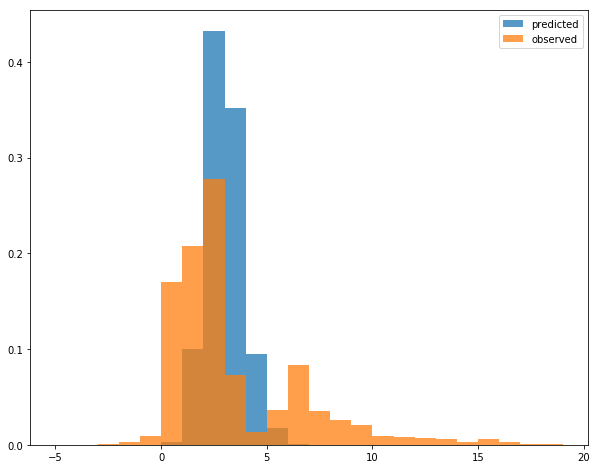

In [48]:
plt.figure(figsize=(10, 8))
plt.hist(pd.Series(linear_svr_y_pred), bins=range(-5,20), alpha=0.75, density=True, label='predicted')
plt.hist(pd.Series(linear_svr_y_test), bins=range(-5,20), alpha=0.75, density=True, label='observed')
plt.legend()
plt.show()

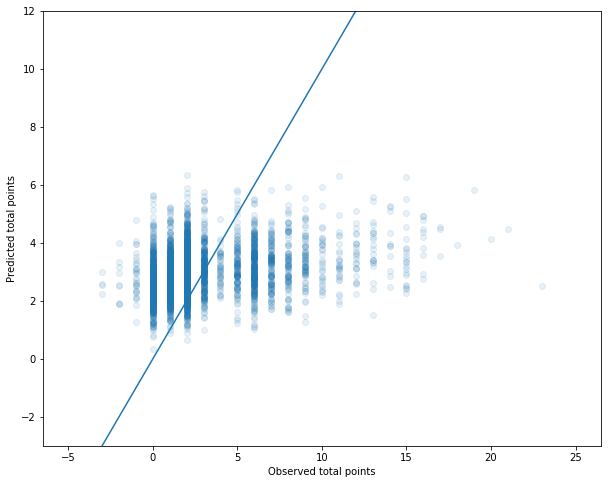

In [49]:
plt.figure(figsize=(10, 8))
plt.scatter(pd.Series(linear_svr_y_test), pd.Series(linear_svr_y_pred), alpha=0.1)
plt.plot(np.linspace(-5, 25), np.linspace(-5, 25))
plt.ylabel('Predicted total points')
plt.xlabel('Observed total points')
plt.ylim((-3, 12))
plt.show()

### Decision tree (lush)

In [50]:
lush_tree_test_loss_arr = []
lush_tree_y_pred_arr = []
lush_tree_y_test_arr = []
lush_tree_df_test_arr = []

for i in range(0, 11):
    lush_tree_model = DecisionTreeRegressor(
        min_samples_leaf=0.065,
        max_features=0.45,
        random_state=i
    )
    
    lush_tree_y_pred, lush_tree_y_test, lush_tree_df_test = predict_test_set(
        element_gameweek_df,
        lush_tree_model,
        standardise=False)
    
    lush_tree_test_loss = (
        mean_absolute_error(lush_tree_y_test, lush_tree_y_pred),
        mean_squared_error(lush_tree_y_test, lush_tree_y_pred),
        r2_score(lush_tree_y_test, lush_tree_y_pred))
    
    lush_tree_test_loss_arr.append(lush_tree_test_loss)
    lush_tree_y_pred_arr.append(lush_tree_y_pred)
    lush_tree_y_test_arr.append(lush_tree_y_test)
    lush_tree_df_test_arr.append(lush_tree_df_test)

lush_tree_test_loss_mean = (
    np.mean([i[0] for i in lush_tree_test_loss_arr]),
    np.mean([i[1] for i in lush_tree_test_loss_arr]),
    np.mean([i[2] for i in lush_tree_test_loss_arr])
)

lush_tree_test_loss_std = (
    np.std([i[0] for i in lush_tree_test_loss_arr]),
    np.std([i[1] for i in lush_tree_test_loss_arr]),
    np.std([i[2] for i in lush_tree_test_loss_arr])
)
    
print(lush_tree_test_loss_mean)
print(lush_tree_test_loss_std)

(2.2877320755615815, 9.656992490866656, 0.0599171931684442)
(0.004906376581918389, 0.04503979089129736, 0.004384505122090818)


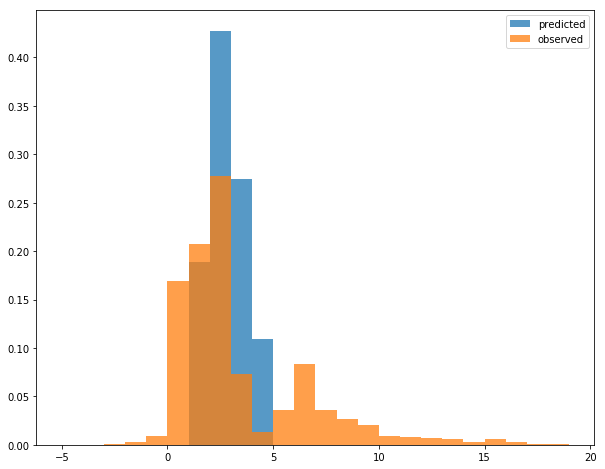

In [51]:
plt.figure(figsize=(10, 8))
plt.hist(pd.Series(lush_tree_y_pred_arr[0]), bins=range(-5,20), alpha=0.75, density=True, label='predicted')
plt.hist(pd.Series(lush_tree_y_test_arr[0]), bins=range(-5,20), alpha=0.75, density=True, label='observed')
plt.legend()
plt.show()

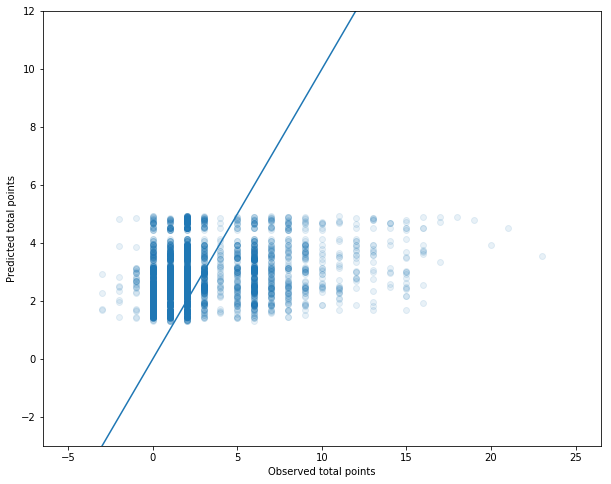

In [52]:
plt.figure(figsize=(10, 8))
plt.scatter(pd.Series(lush_tree_y_test_arr[0]), pd.Series(lush_tree_y_pred_arr[0]), alpha=0.1)
plt.plot(np.linspace(-5, 25), np.linspace(-5, 25))
plt.ylabel('Predicted total points')
plt.xlabel('Observed total points')
plt.ylim((-3, 12))
plt.show()

### Decision tree (stark)

In [53]:
stark_tree_features = ['value', 'expected_avg_total_points_against_opposition_team']

In [54]:
stark_tree_test_loss_arr = []
stark_tree_y_pred_arr = []
stark_tree_y_test_arr = []
stark_tree_df_test_arr = []

for i in range(0, 11):
    stark_tree_model = DecisionTreeRegressor(
        min_samples_leaf=0.027,
        random_state=i
    )
    
    stark_tree_y_pred, stark_tree_y_test, stark_tree_df_test = predict_test_set(
        element_gameweek_df,
        stark_tree_model,
        features=stark_tree_features,
        standardise=False)
    
    stark_tree_test_loss = (
        mean_absolute_error(stark_tree_y_test, stark_tree_y_pred),
        mean_squared_error(stark_tree_y_test, stark_tree_y_pred),
        r2_score(stark_tree_y_test, stark_tree_y_pred))
    
    stark_tree_test_loss_arr.append(stark_tree_test_loss)
    stark_tree_y_pred_arr.append(stark_tree_y_pred)
    stark_tree_y_test_arr.append(stark_tree_y_test)
    stark_tree_df_test_arr.append(stark_tree_df_test)

stark_tree_test_loss_mean = (
    np.mean([i[0] for i in stark_tree_test_loss_arr]),
    np.mean([i[1] for i in stark_tree_test_loss_arr]),
    np.mean([i[2] for i in stark_tree_test_loss_arr])
)

stark_tree_test_loss_std = (
    np.std([i[0] for i in stark_tree_test_loss_arr]),
    np.std([i[1] for i in stark_tree_test_loss_arr]),
    np.std([i[2] for i in stark_tree_test_loss_arr])
)
    
print(stark_tree_test_loss_mean)
print(stark_tree_test_loss_std)

(2.2829757917832736, 9.656592170342476, 0.05995616331803899)
(4.440892098500626e-16, 1.7763568394002505e-15, 0.0)


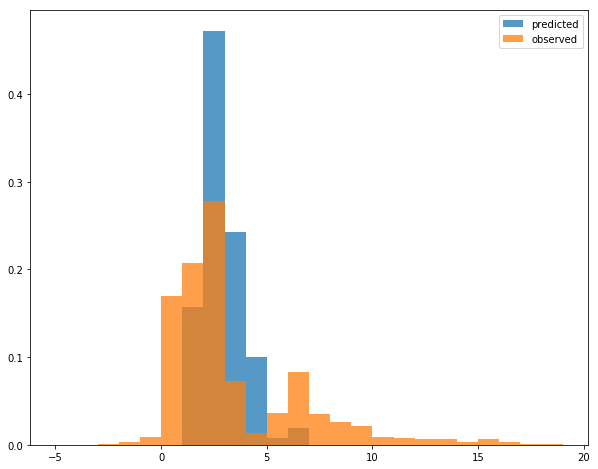

In [55]:
plt.figure(figsize=(10, 8))
plt.hist(pd.Series(stark_tree_y_pred_arr[0]), bins=range(-5,20), alpha=0.75, density=True, label='predicted')
plt.hist(pd.Series(stark_tree_y_test_arr[0]), bins=range(-5,20), alpha=0.75, density=True, label='observed')
plt.legend()
plt.show()

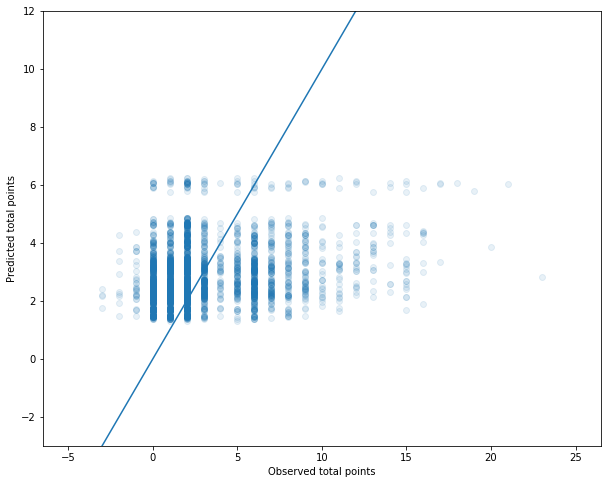

In [56]:
plt.figure(figsize=(10, 8))
plt.scatter(pd.Series(stark_tree_y_test_arr[0]), pd.Series(stark_tree_y_pred_arr[0]), alpha=0.1)
plt.plot(np.linspace(-5, 25), np.linspace(-5, 25))
plt.ylabel('Predicted total points')
plt.xlabel('Observed total points')
plt.ylim((-3, 12))
plt.show()

### Random forest (lush)

In [57]:
lush_forest_test_loss_arr = []
lush_forest_y_pred_arr = []
lush_forest_y_test_arr = []
lush_forest_df_test_arr = []

for i in range(0, 11):
    lush_forest_model = RandomForestRegressor(
        n_estimators=120,
        min_samples_leaf=0.015,
        max_features=0.84,
        random_state=i)
    
    lush_forest_y_pred, lush_forest_y_test, lush_forest_df_test = predict_test_set(
        element_gameweek_df,
        lush_forest_model,
        standardise=False)
    
    lush_forest_test_loss = (
        mean_absolute_error(lush_forest_y_test, lush_forest_y_pred),
        mean_squared_error(lush_forest_y_test, lush_forest_y_pred),
        r2_score(lush_forest_y_test, lush_forest_y_pred))
    
    lush_forest_test_loss_arr.append(lush_forest_test_loss)
    lush_forest_y_pred_arr.append(lush_forest_y_pred)
    lush_forest_y_test_arr.append(lush_forest_y_test)
    lush_forest_df_test_arr.append(lush_forest_df_test)

lush_forest_test_loss_mean = (
    np.mean([i[0] for i in lush_forest_test_loss_arr]),
    np.mean([i[1] for i in lush_forest_test_loss_arr]),
    np.mean([i[2] for i in lush_forest_test_loss_arr])
)

lush_forest_test_loss_std = (
    np.std([i[0] for i in lush_forest_test_loss_arr]),
    np.std([i[1] for i in lush_forest_test_loss_arr]),
    np.std([i[2] for i in lush_forest_test_loss_arr])
)
    
print(lush_forest_test_loss_mean)
print(lush_forest_test_loss_std)

(2.2493522771022296, 9.41746515753065, 0.08323454875801888)
(0.0013054211876599995, 0.005485919481248648, 0.0005340398254282426)


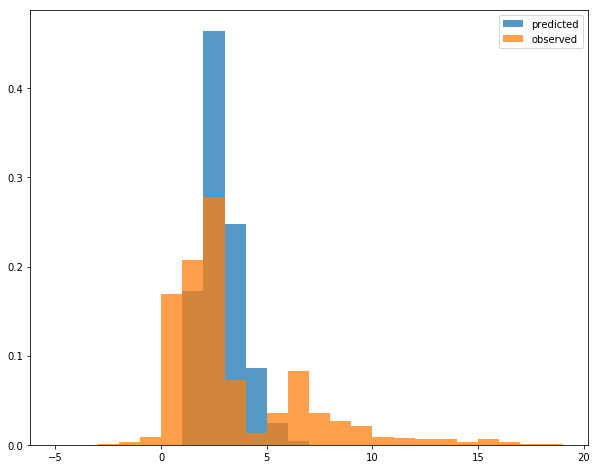

In [58]:
plt.figure(figsize=(10, 8))
plt.hist(pd.Series(lush_forest_y_pred_arr[0]), bins=range(-5,20), alpha=0.75, density=True, label='predicted')
plt.hist(pd.Series(lush_forest_y_test_arr[0]), bins=range(-5,20), alpha=0.75, density=True, label='observed')
plt.legend()
plt.show()

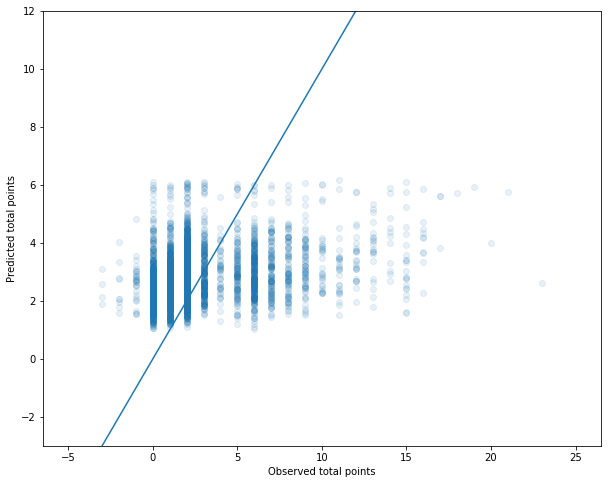

In [59]:
plt.figure(figsize=(10, 8))
plt.scatter(pd.Series(lush_forest_y_test_arr[0]), pd.Series(lush_forest_y_pred_arr[0]), alpha=0.1)
plt.plot(np.linspace(-5, 25), np.linspace(-5, 25))
plt.ylabel('Predicted total points')
plt.xlabel('Observed total points')
plt.ylim((-3, 12))
plt.show()

### Random forest (stark)

In [60]:
stark_forest_features = [
    'value', 'is_late', 'rolling_avg_total_points_element',
    'rolling_var_total_points_element', 'rolling_avg_minutes_element_p3',
    'rolling_avg_bps_element', 'rolling_avg_bonus_element',
    'rolling_avg_goals_scored_element', 'rolling_avg_minutes_element',
    'rolling_avg_clean_sheets_element', 'rolling_avg_completed_passes_element',
    'rolling_avg_recoveries_element', 'rolling_avg_key_passes_element',
    'rolling_avg_tackled_element', 'rolling_avg_dribbles_element',
    'rolling_avg_clearances_blocks_interceptions_element',
    'rolling_avg_target_missed_element', 'rolling_avg_fouls_element',
    'rolling_avg_tackles_element', 'rolling_avg_big_chances_missed_element',
    'rolling_avg_goals_conceded_element',
    'rolling_avg_total_points_element_type',
    'rolling_avg_total_points_own_team',
    'rolling_avg_total_points_opposition_team',
    'rolling_avg_total_points_against_opposition_team',
    'rolling_avg_total_points_against_opposition_team_element_type',
    'expected_avg_total_points_against_opposition_team',
    'expected_avg_total_points_at_ground'
]

In [61]:
stark_forest_test_loss_arr = []
stark_forest_y_pred_arr = []
stark_forest_y_test_arr = []
stark_forest_df_test_arr = []

for i in range(0, 11):
    stark_forest_model = RandomForestRegressor(
        n_estimators=120,
        min_samples_leaf=0.0135,
        max_features=0.73,
        random_state=i)
    
    stark_forest_y_pred, stark_forest_y_test, stark_forest_df_test = predict_test_set(
        element_gameweek_df,
        stark_forest_model,
        features=stark_forest_features,
        standardise=False)
    
    stark_forest_test_loss = (
        mean_absolute_error(stark_forest_y_test, stark_forest_y_pred),
        mean_squared_error(stark_forest_y_test, stark_forest_y_pred),
        r2_score(stark_forest_y_test, stark_forest_y_pred))
    
    stark_forest_test_loss_arr.append(stark_forest_test_loss)
    stark_forest_y_pred_arr.append(stark_forest_y_pred)
    stark_forest_y_test_arr.append(stark_forest_y_test)
    stark_forest_df_test_arr.append(stark_forest_df_test)

stark_forest_test_loss_mean = (
    np.mean([i[0] for i in stark_forest_test_loss_arr]),
    np.mean([i[1] for i in stark_forest_test_loss_arr]),
    np.mean([i[2] for i in stark_forest_test_loss_arr])
)

stark_forest_test_loss_std = (
    np.std([i[0] for i in stark_forest_test_loss_arr]),
    np.std([i[1] for i in stark_forest_test_loss_arr]),
    np.std([i[2] for i in stark_forest_test_loss_arr])
)
    
print(stark_forest_test_loss_mean)
print(stark_forest_test_loss_std)

(2.2499486050760966, 9.421637530014817, 0.08282837927618786)
(0.0014273062285331216, 0.007622851394337685, 0.0007420645238801297)


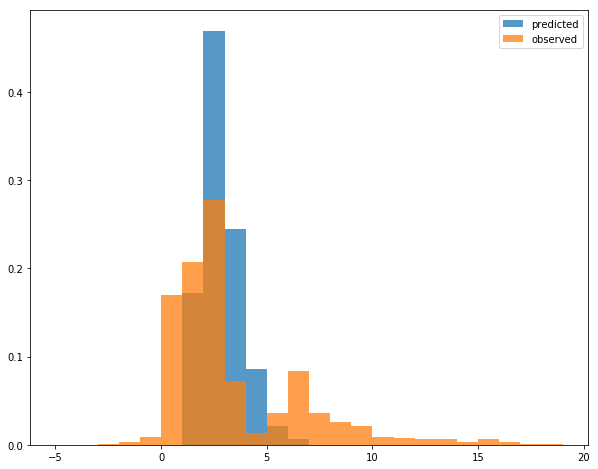

In [62]:
plt.figure(figsize=(10, 8))
plt.hist(pd.Series(stark_forest_y_pred_arr[0]), bins=range(-5,20), alpha=0.75, density=True, label='predicted')
plt.hist(pd.Series(stark_forest_y_test_arr[0]), bins=range(-5,20), alpha=0.75, density=True, label='observed')
plt.legend()
plt.show()

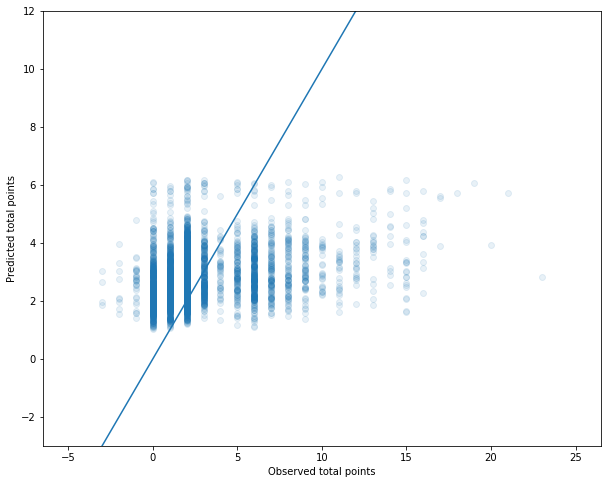

In [63]:
plt.figure(figsize=(10, 8))
plt.scatter(pd.Series(stark_forest_y_test_arr[0]), pd.Series(stark_forest_y_pred_arr[0]), alpha=0.1)
plt.plot(np.linspace(-5, 25), np.linspace(-5, 25))
plt.ylabel('Predicted total points')
plt.xlabel('Observed total points')
plt.ylim((-3, 12))
plt.show()

### Gradient boosted trees (lush)

In [64]:
lush_boost_test_loss_arr = []
lush_boost_y_pred_arr = []
lush_boost_y_test_arr = []
lush_boost_df_test_arr = []

for i in range(0, 11):
    lush_boost_model = GradientBoostingRegressor(
        n_estimators=120,
        max_features=0.61,
        min_samples_leaf=0.015,
        learning_rate=0.035,
        criterion='mse',
        random_state=i)
    
    lush_boost_y_pred, lush_boost_y_test, lush_boost_df_test = predict_test_set(
        element_gameweek_df,
        lush_boost_model,
        standardise=False)
    
    lush_boost_test_loss = (
        mean_absolute_error(lush_boost_y_test, lush_boost_y_pred),
        mean_squared_error(lush_boost_y_test, lush_boost_y_pred),
        r2_score(lush_boost_y_test, lush_boost_y_pred))
    
    lush_boost_test_loss_arr.append(lush_boost_test_loss)
    lush_boost_y_pred_arr.append(lush_boost_y_pred)
    lush_boost_y_test_arr.append(lush_boost_y_test)
    lush_boost_df_test_arr.append(lush_boost_df_test)

lush_boost_test_loss_mean = (
    np.mean([i[0] for i in lush_boost_test_loss_arr]),
    np.mean([i[1] for i in lush_boost_test_loss_arr]),
    np.mean([i[2] for i in lush_boost_test_loss_arr])
)

lush_boost_test_loss_std = (
    np.std([i[0] for i in lush_boost_test_loss_arr]),
    np.std([i[1] for i in lush_boost_test_loss_arr]),
    np.std([i[2] for i in lush_boost_test_loss_arr])
)
    
print(lush_boost_test_loss_mean)
print(lush_boost_test_loss_std)

(2.2516297347563405, 9.396850249345256, 0.08524135582220882)
(0.0015397383438278073, 0.007553625033223461, 0.0007353255197932244)


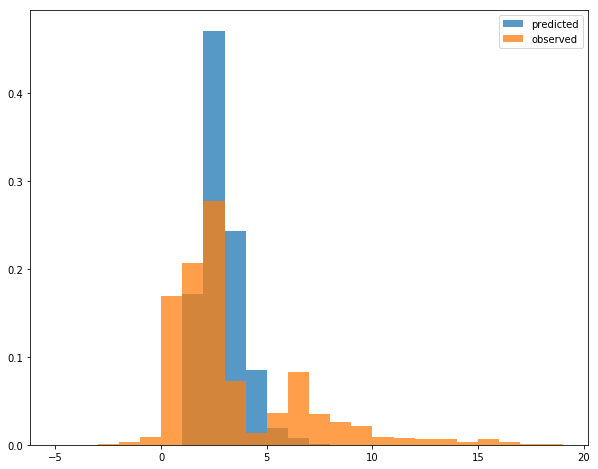

In [65]:
plt.figure(figsize=(10, 8))
plt.hist(pd.Series(lush_boost_y_pred_arr[0]), bins=range(-5,20), alpha=0.75, density=True, label='predicted')
plt.hist(pd.Series(lush_boost_y_test_arr[0]), bins=range(-5,20), alpha=0.75, density=True, label='observed')
plt.legend()
plt.show()

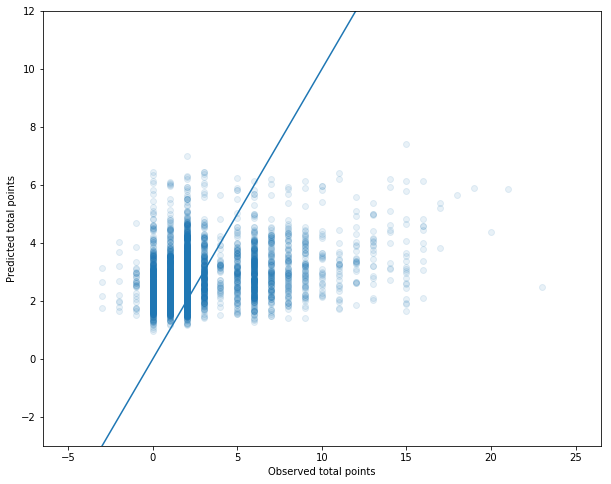

In [66]:
plt.figure(figsize=(10, 8))
plt.scatter(pd.Series(lush_boost_y_test_arr[0]), pd.Series(lush_boost_y_pred_arr[0]), alpha=0.1)
plt.plot(np.linspace(-5, 25), np.linspace(-5, 25))
plt.ylabel('Predicted total points')
plt.xlabel('Observed total points')
plt.ylim((-3, 12))
plt.show()

### Gradient boosted trees (stark)

In [67]:
stark_boost_features = [
    'value', 'rolling_avg_minutes_element_p3', 'rolling_avg_minutes_element',
    'rolling_avg_key_passes_element',
    'rolling_avg_clearances_blocks_interceptions_element',
    'rolling_avg_big_chances_missed_element',
    'rolling_avg_total_points_own_team',
    'rolling_avg_total_points_opposition_team',
    'rolling_avg_total_points_against_opposition_team',
    'rolling_avg_total_points_against_opposition_team_element_type',
    'expected_avg_total_points_against_opposition_team',
    'expected_avg_total_points_at_ground'
]

In [68]:
stark_boost_test_loss_arr = []
stark_boost_y_pred_arr = []
stark_boost_y_test_arr = []
stark_boost_df_test_arr = []

for i in range(0, 11):
    stark_boost_model = GradientBoostingRegressor(
        n_estimators=120,
        max_features=0.8,
        min_samples_leaf=0.02,
        learning_rate=0.05,
        criterion='mse',
        random_state=i)
    
    stark_boost_y_pred, stark_boost_y_test, stark_boost_df_test = predict_test_set(
        element_gameweek_df,
        stark_boost_model,
        features=stark_boost_features,
        standardise=False)
    
    stark_boost_test_loss = (
        mean_absolute_error(stark_boost_y_test, stark_boost_y_pred),
        mean_squared_error(stark_boost_y_test, stark_boost_y_pred),
        r2_score(stark_boost_y_test, stark_boost_y_pred))
    
    stark_boost_test_loss_arr.append(stark_boost_test_loss)
    stark_boost_y_pred_arr.append(stark_boost_y_pred)
    stark_boost_y_test_arr.append(stark_boost_y_test)
    stark_boost_df_test_arr.append(stark_boost_df_test)

stark_boost_test_loss_mean = (
    np.mean([i[0] for i in stark_boost_test_loss_arr]),
    np.mean([i[1] for i in stark_boost_test_loss_arr]),
    np.mean([i[2] for i in stark_boost_test_loss_arr])
)

stark_boost_test_loss_std = (
    np.std([i[0] for i in stark_boost_test_loss_arr]),
    np.std([i[1] for i in stark_boost_test_loss_arr]),
    np.std([i[2] for i in stark_boost_test_loss_arr])
)
    
print(stark_boost_test_loss_mean)
print(stark_boost_test_loss_std)

(2.2516206166705124, 9.42251897263653, 0.08274257315646016)
(0.0009990995927601262, 0.007921661806543688, 0.000771152931195623)


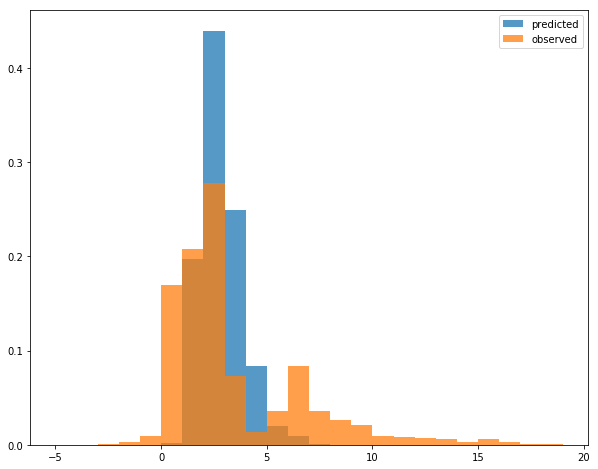

In [69]:
plt.figure(figsize=(10, 8))
plt.hist(pd.Series(stark_boost_y_pred_arr[0]), bins=range(-5,20), alpha=0.75, density=True, label='predicted')
plt.hist(pd.Series(stark_boost_y_test_arr[0]), bins=range(-5,20), alpha=0.75, density=True, label='observed')
plt.legend()
plt.show()

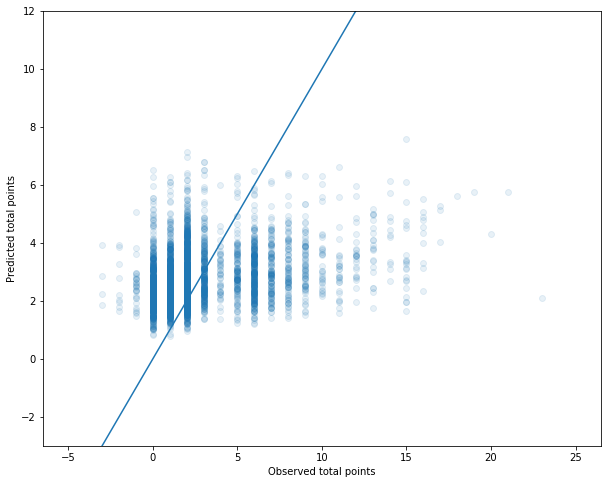

In [70]:
plt.figure(figsize=(10, 8))
plt.scatter(pd.Series(stark_boost_y_test_arr[0]), pd.Series(stark_boost_y_pred_arr[0]), alpha=0.1)
plt.plot(np.linspace(-5, 25), np.linspace(-5, 25))
plt.ylabel('Predicted total points')
plt.xlabel('Observed total points')
plt.ylim((-3, 12))
plt.show()

## Constructing teams

### Linear regression

In [71]:
(
    lr_first_team_arr,
    lr_bench_arr,
    lr_total_points_arr,
    lr_predicted_total_points_arr,
    lr_team_df_arr,
    lr_transfers_arr
) = \
construct_event_teams_from_existing(lr_df_test, verbose=1)

predicting event 21
predicting event 22
predicting event 23
predicting event 24
predicting event 25
predicting event 26
predicting event 27
predicting event 28
predicting event 29
predicting event 30
predicting event 31
predicting event 32
predicting event 33
predicting event 34
predicting event 35
predicting event 36
predicting event 37
predicting event 38


In [72]:
lr_teams_total_points = sum(lr_total_points_arr)
lr_teams_total_points

686

### Ridge regression (lush)

In [73]:
(
    lush_ridge_first_team_arr,
    lush_ridge_bench_arr,
    lush_ridge_total_points_arr,
    lush_ridge_predicted_total_points_arr,
    lush_ridge_team_df_arr,
    lush_ridge_transfers_arr
) = \
construct_event_teams_from_existing(lush_ridge_df_test, verbose=1)

predicting event 21
predicting event 22
predicting event 23
predicting event 24
predicting event 25
predicting event 26
predicting event 27
predicting event 28
predicting event 29
predicting event 30
predicting event 31
predicting event 32
predicting event 33
predicting event 34
predicting event 35
predicting event 36
predicting event 37
predicting event 38


In [74]:
lush_ridge_teams_total_points = sum(lush_ridge_total_points_arr)
lush_ridge_teams_total_points

995

In [95]:
lush_ridge_total_points_arr

[48, 62, 51, 36, 90, 76, 25, 56, 31, 24, 7, 81, 50, 69, 65, 112, 58, 54]

In [94]:
lush_ridge_transfers_arr

[[],
 [set(), set()],
 [set(), set()],
 [{8.0}, {425.0}],
 [{172.0, 270.0, 280.0}, {17.0, 23.0, 253.0}],
 [set(), set()],
 [{247.0, 253.0, 257.0, 364.0, 367.0, 425.0, 465.0, 482.0},
  {115.0, 116.0, 122.0, 172.0, 270.0, 280.0, 391.0, 484.0}],
 [{343.0}, {465.0}],
 [{306.0}, {257.0}],
 [{220.0}, {8.0}],
 [{40.0, 122.0, 234.0, 251.0, 400.0, 465.0, 579.0},
  {302.0, 306.0, 343.0, 364.0, 367.0, 425.0, 454.0}],
 [{113.0, 142.0, 270.0, 271.0, 276.0}, {234.0, 251.0, 253.0, 465.0, 482.0}],
 [{43.0, 172.0, 234.0, 251.0, 253.0}, {220.0, 270.0, 271.0, 276.0, 579.0}],
 [{49.0}, {234.0}],
 [{270.0}, {122.0}],
 [set(), set()],
 [{430.0}, {49.0}],
 [{330.0}, {142.0}]]

In [100]:
lush_ridge_team_df_arr[-1]

,safe_web_name,element,value,element_type,is_first_team,predicted_total_points,total_points,minutes,is_captain
9613,salah,253,132,3,1,7.076982,3,90,1
10259,sterling,270,117,3,1,5.968216,5,90,0
9537,mane,251,103,3,1,5.756733,15,90,0
9385,robertson,247,67,2,1,4.811505,6,83,0
1633,wilson,43,69,4,1,4.480270,2,90,0
6535,sigurdsson,172,74,3,1,4.073800,5,90,0
1519,fraser,40,64,3,1,3.959262,2,90,0
4293,azpilicueta,113,64,2,1,3.557674,6,90,0
12539,bertrand,330,48,2,1,3.427767,2,90,0
15199,fabianski,400,47,1,1,3.245143,4,90,0


### Ridge regression (stark)

In [75]:
(
    stark_ridge_first_team_arr,
    stark_ridge_bench_arr,
    stark_ridge_total_points_arr,
    stark_ridge_predicted_total_points_arr,
    stark_ridge_team_df_arr,
    stark_ridge_transfers_arr
) = \
construct_event_teams_from_existing(stark_ridge_df_test, verbose=1)

predicting event 21
predicting event 22
predicting event 23
predicting event 24
predicting event 25
predicting event 26
predicting event 27
predicting event 28
predicting event 29
predicting event 30
predicting event 31
predicting event 32
predicting event 33
predicting event 34
predicting event 35
predicting event 36
predicting event 37
predicting event 38


In [76]:
stark_ridge_teams_total_points = sum(stark_ridge_total_points_arr)
stark_ridge_teams_total_points

986

### Lasso regression

In [77]:
(
    lasso_first_team_arr,
    lasso_bench_arr,
    lasso_total_points_arr,
    lasso_predicted_total_points_arr,
    lasso_team_df_arr,
    lasso_transfers_arr
) = \
construct_event_teams_from_existing(lasso_df_test, verbose=1)

predicting event 21
predicting event 22
predicting event 23
predicting event 24
predicting event 25
predicting event 26
predicting event 27
predicting event 28
predicting event 29
predicting event 30
predicting event 31
predicting event 32
predicting event 33
predicting event 34
predicting event 35
predicting event 36
predicting event 37
predicting event 38


In [78]:
lasso_teams_total_points = sum(lasso_total_points_arr)
lasso_teams_total_points

948

### Radial basis SVM regression

In [79]:
(
    rbf_svr_first_team_arr,
    rbf_svr_bench_arr,
    rbf_svr_total_points_arr,
    rbf_svr_predicted_total_points_arr,
    rbf_svr_team_df_arr,
    rbf_svr_transfers_arr
) = \
construct_event_teams_from_existing(rbf_svr_df_test, verbose=1)

predicting event 21
predicting event 22
predicting event 23
predicting event 24
predicting event 25
predicting event 26
predicting event 27
predicting event 28
predicting event 29
predicting event 30
predicting event 31
predicting event 32
predicting event 33
predicting event 34
predicting event 35
predicting event 36
predicting event 37
predicting event 38


In [80]:
rbf_svr_teams_total_points = sum(rbf_svr_total_points_arr)
rbf_svr_teams_total_points

968

### Linear basis SVM regression

In [81]:
(
    linear_svr_first_team_arr,
    linear_svr_bench_arr,
    linear_svr_total_points_arr,
    linear_svr_predicted_total_points_arr,
    linear_svr_team_df_arr,
    linear_svr_transfers_arr
) = \
construct_event_teams_from_existing(linear_svr_df_test, verbose=1)

predicting event 21
predicting event 22
predicting event 23
predicting event 24
predicting event 25
predicting event 26
predicting event 27
predicting event 28
predicting event 29
predicting event 30
predicting event 31
predicting event 32
predicting event 33
predicting event 34
predicting event 35
predicting event 36
predicting event 37
predicting event 38


In [82]:
linear_svr_teams_total_points = sum(linear_svr_total_points_arr)
linear_svr_teams_total_points

976

### Decision tree (lush)

In [83]:
lush_tree_teams_total_points_arr = []

for i in range(0, len(lush_tree_df_test_arr)):
    (
        lush_tree_first_team_arr,
        lush_tree_bench_arr,
        lush_tree_total_points_arr,
        lush_tree_predicted_total_points_arr,
        lush_tree_team_df_arr,
        lush_tree_transfers_arr
    ) = \
    construct_event_teams_from_existing(lush_tree_df_test_arr[i], verbose=0)
    
    lush_tree_teams_total_points = sum(lush_tree_total_points_arr)
    lush_tree_teams_total_points_arr.append(lush_tree_teams_total_points)

lush_tree_teams_total_points_mean = np.mean(lush_tree_teams_total_points_arr) 
lush_tree_teams_total_points_std = np.std(lush_tree_teams_total_points_arr)
    
print(lush_tree_teams_total_points_mean)
print(lush_tree_teams_total_points_std)

925.4545454545455
42.99336869874371


### Decision tree (stark)

In [84]:
stark_tree_teams_total_points_arr = []

for i in range(0, len(stark_tree_df_test_arr)):
    (
        stark_tree_first_team_arr,
        stark_tree_bench_arr,
        stark_tree_total_points_arr,
        stark_tree_predicted_total_points_arr,
        stark_tree_team_df_arr,
        stark_tree_transfers_arr
    ) = \
    construct_event_teams_from_existing(stark_tree_df_test_arr[i], verbose=0)
    
    stark_tree_teams_total_points = sum(stark_tree_total_points_arr)
    stark_tree_teams_total_points_arr.append(stark_tree_teams_total_points)

stark_tree_teams_total_points_mean = np.mean(stark_tree_teams_total_points_arr) 
stark_tree_teams_total_points_std = np.std(stark_tree_teams_total_points_arr)
    
print(stark_tree_teams_total_points_mean)
print(stark_tree_teams_total_points_std)

960.0
0.0


### Random forest (lush)

In [85]:
lush_forest_teams_total_points_arr = []

for i in range(0, len(lush_forest_df_test_arr)):
    (
        lush_forest_first_team_arr,
        lush_forest_bench_arr,
        lush_forest_total_points_arr,
        lush_forest_predicted_total_points_arr,
        lush_forest_team_df_arr,
        lush_forest_transfers_arr
    ) = \
    construct_event_teams_from_existing(lush_forest_df_test_arr[i], verbose=0)
    
    lush_forest_teams_total_points = sum(lush_forest_total_points_arr)
    lush_forest_teams_total_points_arr.append(lush_forest_teams_total_points)

lush_forest_teams_total_points_mean = np.mean(lush_forest_teams_total_points_arr) 
lush_forest_teams_total_points_std = np.std(lush_forest_teams_total_points_arr)
    
print(lush_forest_teams_total_points_mean)
print(lush_forest_teams_total_points_std)

889.8181818181819
29.743809690018413


### Random forest (stark)

In [86]:
stark_forest_teams_total_points_arr = []

for i in range(0, len(stark_forest_df_test_arr)):
    (
        stark_forest_first_team_arr,
        stark_forest_bench_arr,
        stark_forest_total_points_arr,
        stark_forest_predicted_total_points_arr,
        stark_forest_team_df_arr,
        stark_forest_transfers_arr
    ) = \
    construct_event_teams_from_existing(stark_forest_df_test_arr[i], verbose=0)
    
    stark_forest_teams_total_points = sum(stark_forest_total_points_arr)
    stark_forest_teams_total_points_arr.append(stark_forest_teams_total_points)

stark_forest_teams_total_points_mean = np.mean(stark_forest_teams_total_points_arr) 
stark_forest_teams_total_points_std = np.std(stark_forest_teams_total_points_arr)
    
print(stark_forest_teams_total_points_mean)
print(stark_forest_teams_total_points_std)

905.8181818181819
42.26930582439263


### Gradient boosted trees (lush)

In [87]:
lush_boost_teams_total_points_arr = []

for i in range(0, len(lush_boost_df_test_arr)):
    (
        lush_boost_first_team_arr,
        lush_boost_bench_arr,
        lush_boost_total_points_arr,
        lush_boost_predicted_total_points_arr,
        lush_boost_team_df_arr,
        lush_boost_transfers_arr
    ) = \
    construct_event_teams_from_existing(lush_boost_df_test_arr[i], verbose=0)
    
    lush_boost_teams_total_points = sum(lush_boost_total_points_arr)
    lush_boost_teams_total_points_arr.append(lush_boost_teams_total_points)

lush_boost_teams_total_points_mean = np.mean(lush_boost_teams_total_points_arr) 
lush_boost_teams_total_points_std = np.std(lush_boost_teams_total_points_arr)
    
print(lush_boost_teams_total_points_mean)
print(lush_boost_teams_total_points_std)

916.0909090909091
36.82255866240532


### Gradient boosted trees (stark)

In [88]:
stark_boost_teams_total_points_arr = []

for i in range(0, len(stark_boost_df_test_arr)):
    (
        stark_boost_first_team_arr,
        stark_boost_bench_arr,
        stark_boost_total_points_arr,
        stark_boost_predicted_total_points_arr,
        stark_boost_team_df_arr,
        stark_boost_transfers_arr
    ) = \
    construct_event_teams_from_existing(stark_boost_df_test_arr[i], verbose=0)
    
    stark_boost_teams_total_points = sum(stark_boost_total_points_arr)
    stark_boost_teams_total_points_arr.append(stark_boost_teams_total_points)

stark_boost_teams_total_points_mean = np.mean(stark_boost_teams_total_points_arr) 
stark_boost_teams_total_points_std = np.std(stark_boost_teams_total_points_arr)
    
print(stark_boost_teams_total_points_mean)
print(stark_boost_teams_total_points_std)

887.1818181818181
27.412068283938478


### Random benchmark

In [89]:
random_benchmark_df_test = stark_boost_df_test.copy()

In [90]:
random_benchmark_df_test['predicted_total_points'] = \
np.random.random(len(stark_boost_df_test['predicted_total_points'])) * 7

In [91]:
random_benchmark_teams_total_points_arr = []

for i in range(0, 11):
    (
        random_benchmark_first_team_arr,
        random_benchmark_bench_arr,
        random_benchmark_total_points_arr,
        random_benchmark_predicted_total_points_arr,
        random_benchmark_team_df_arr,
        random_benchmark_transfers_arr
    ) = \
    construct_event_teams_from_existing(random_benchmark_df_test, verbose=0)
    
    random_benchmark_teams_total_points = sum(random_benchmark_total_points_arr)
    random_benchmark_teams_total_points_arr.append(random_benchmark_teams_total_points)

random_benchmark_teams_total_points_mean = np.mean(random_benchmark_teams_total_points_arr) 
random_benchmark_teams_total_points_std = np.std(random_benchmark_teams_total_points_arr)
    
print(random_benchmark_teams_total_points_mean)
print(random_benchmark_teams_total_points_std)

376.0
0.0


## Summary

In [92]:
pd.DataFrame([
    ('Linear regression', lr_test_loss[0], lr_test_loss[1], lr_test_loss[2]),
    ('Ridge regression (lush)', lush_ridge_test_loss[0], lush_ridge_test_loss[1], lush_ridge_test_loss[2]),
    ('Ridge regression (stark)', stark_ridge_test_loss[0], stark_ridge_test_loss[1], stark_ridge_test_loss[2]),
    ('Lasso regression', lasso_test_loss[0], lasso_test_loss[1], lasso_test_loss[2]),
    ('Radius basis SVM regression', rbf_svr_test_loss[0], rbf_svr_test_loss[1], rbf_svr_test_loss[2]),
    ('Linear basis SVM regression', linear_svr_test_loss[0], linear_svr_test_loss[1], linear_svr_test_loss[2]),
    ('Decision tree (lush)', lush_tree_test_loss_mean[0], lush_tree_test_loss_mean[1], lush_tree_test_loss_mean[2]),
    ('Decision tree (stark)', stark_tree_test_loss_mean[0], stark_tree_test_loss_mean[1], stark_tree_test_loss_mean[2]),
    ('Random forest (lush)', lush_forest_test_loss_mean[0], lush_forest_test_loss_mean[1], lush_forest_test_loss_mean[2]),
    ('Random forest (stark)', stark_forest_test_loss_mean[0], stark_forest_test_loss_mean[1], stark_forest_test_loss_mean[2]),
    ('Gradient boosted trees (lush)', lush_boost_test_loss_mean[0], lush_boost_test_loss_mean[1], lush_boost_test_loss_mean[2]),
    ('Gradient boosted trees (stark)', stark_boost_test_loss_mean[0], stark_boost_test_loss_mean[1], stark_boost_test_loss_mean[2]),
], columns=['model', 'MAE', 'MSE', 'r2'])

,model,MAE,MSE,r2
0,Linear regression,2.389162,10.275135,-0.000257
1,Ridge regression (lush),2.259268,9.308154,0.093876
2,Ridge regression (stark),2.282544,9.594887,0.065963
3,Lasso regression,2.297304,9.691294,0.056578
4,Radius basis SVM regression,2.280704,9.431990,0.081821
5,Linear basis SVM regression,2.315303,9.458456,0.079244
6,Decision tree (lush),2.287732,9.656992,0.059917
7,Decision tree (stark),2.282976,9.656592,0.059956
8,Random forest (lush),2.249352,9.417465,0.083235
9,Random forest (stark),2.249949,9.421638,0.082828


In [93]:
pd.DataFrame([
    ('Random benchmark', random_benchmark_teams_total_points),
    ('Linear regression', lr_teams_total_points),
    ('Ridge regression (lush)', lush_ridge_teams_total_points),
    ('Ridge regression (stark)', stark_ridge_teams_total_points),
    ('Lasso regression', lasso_teams_total_points),
    ('Radius basis SVM regression', linear_svr_teams_total_points),
    ('Linear basis SVM regression', rbf_svr_teams_total_points),
    ('Decision tree (lush)', lush_tree_teams_total_points_mean),
    ('Decision tree (stark)', stark_tree_teams_total_points_mean),
    ('Random forest (lush)', lush_forest_teams_total_points_mean),
    ('Random forest (stark)', stark_forest_teams_total_points_mean),
    ('Gradient boosted trees (lush)', lush_boost_teams_total_points_mean),
    ('Gradient boosted trees (stark)', stark_boost_teams_total_points_mean),
], columns=['model', 'teams total points']).round(1)

,model,teams total points
0,Random benchmark,376.0
1,Linear regression,686.0
2,Ridge regression (lush),995.0
3,Ridge regression (stark),986.0
4,Lasso regression,948.0
5,Radius basis SVM regression,976.0
6,Linear basis SVM regression,968.0
7,Decision tree (lush),925.5
8,Decision tree (stark),960.0
9,Random forest (lush),889.8
